In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R 
import pickle 
import os 
import glob 
from mpl_toolkits.mplot3d import Axes3D 
import random 
import heapq

In [10]:
# functions
# function to compute distance between a line segment and point 
def dist_point_to_segment(P0, PA, PB): 
    len_sq = np.linalg.norm(PB-PA)**2  
    if len_sq == 0.0: 
        return np.linalg.norm(P0-PA) 
    d = np.linalg.norm(np.linalg.cross((P0-PA),(P0-PB))) / np.linalg.norm(PB-PA) # see: https://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html 
    dot = np.dot((P0-PA),(PB-PA)) 
    p = dot / len_sq # see: https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    if p < 0: 
        dist = np.linalg.norm(P0-PA)  
    elif p > 1: 
        dist = np.linalg.norm(P0-PB) 
    else: 
        dist = d  
    return dist 

# function to classify hole point into hole geometry element 
def classify_hole_point(point, hole_parameters, tol=0.1, flag_single_class=True): 
    x = point[0]
    y = point[1] 
    z = point[2] 
    hole_geom_class = [] 

    RR = hole_parameters['R'] 
    a = hole_parameters['a'] 
    b = hole_parameters['b']  
    d = hole_parameters['d']  
    z_h_top = -(d/2 - np.sqrt((d/2)**2 - (a/2)**2))
    z_h_bot = -d + (d/2 - np.sqrt((d/2)**2 - (a/2)**2));  

    # vertices 
    HV1 = np.array([+a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_top])
    HV2 = np.array([-a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_top])
    HV3 = np.array([+a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_top]) 
    HV4 = np.array([-a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_top]) 
    HV1_bot = np.array([+a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_bot])
    HV2_bot = np.array([-a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_bot])
    HV3_bot = np.array([+a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_bot]) 
    HV4_bot = np.array([-a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_bot]) 

    vertices = [HV1, HV2, HV3, HV4] 
    vertices_class = ['HV1','HV2','HV3','HV4'] 
    for i, vertex in enumerate(vertices): 
        dist = np.linalg.norm(point - vertex) 
        if dist < tol: 
            hole_geom_class.append(vertices_class[i]) 
            if flag_single_class: 
                return vertices_class[i] 

    # curved edges 
    hole_theta_arc = np.pi - np.arcsin((a/2)/RR) 
    theta = np.arctan2(-x, y) 
    rp = np.sqrt(x**2 + y**2) 

    if x < (d/2):  import heapq
    HE3 = [HV1, HV1_bot]
    HE4 = [HV2, HV2_bot]
    HE5 = [HV3, HV3_bot]
    HE6 = [HV4, HV4_bot]

    # check straight edges 
    straight_edges = [HE3, HE4, HE5, HE6]
    straight_edges_class = ['HE3', 'HE4', 'HE5', 'HE6']  
    for i, straight_edge in enumerate(straight_edges): 
        dist = dist_point_to_segment(point, straight_edge[0], straight_edge[1])  
        if dist < tol: 
            hole_geom_class.append(straight_edges_class[i]) 
            if flag_single_class: 
                return straight_edges_class[i] 

    # curved faces 
    z_curved_edge_theoretical = -(d/2) + np.sqrt((d/2)**2 - x**2) 
    if theta > 0 and theta <= hole_theta_arc and np.abs(rp - RR) < tol and z < z_curved_edge_theoretical and z > -d-z_curved_edge_theoretical:  
        hole_geom_class.append('HF1')
        if flag_single_class: 
            return 'HF1'
    elif theta < 0 and theta >= -hole_theta_arc and np.abs(rp - RR) < tol and z < z_curved_edge_theoretical and z > -d-z_curved_edge_theoretical:
        hole_geom_class.append('HF2')
        if flag_single_class: 
            return 'HF2' 

    # if not hole_geom_class: 
    #     hole_geom_class = 'None' 

    return hole_geom_class 

# function to classify peg point into peg geometry element 
def classify_peg_point(point, peg_parameters, tol=0.1, flag_single_class=True):

    x = point[0]
    y = point[1] 
    z = point[2] 
    peg_geom_class = []  

    r = peg_parameters['r'] 
    e = peg_parameters['e'] 
    lp = peg_parameters['lp']  
    hp = peg_parameters['hp']  
    
    # z_h_top = -(d/2 - np.sqrt((d/2)**2 - (a/2)**2))

    # z_h_bot = -d + (d/2 - np.sqrt((d/2)**2 - (a/2)**2));  

    # define vertices 
    PV1 = np.array([+e, -np.sqrt(r**2 - e**2),  0])
    PV2 = np.array([-e, -np.sqrt(r**2 - e**2), 0])
    PV3 = np.array([+e, -lp, 0]) 
    PV4 = np.array([-e, -lp, 0]) 

    # straight edges 
    PE3 = [PV1, PV3]
    PE4 = [PV2, PV4] 
    
    # check straight edges 
    straight_edges = [PE3, PE4] 
    straight_edges_class = ['PE3', 'PE4']   
    for i, straight_edge in enumerate(straight_edges): 
        dist = dist_point_to_segment(point, straight_edge[0], straight_edge[1])  
        if dist < tol: 
            peg_geom_class.append(straight_edges_class[i]) 
            if flag_single_class: 
                return straight_edges_class[i] 
    
    # curved edges 
    peg_theta_arc = np.pi - np.arcsin(e/r) 
    theta = np.arctan2(-x, y) 
    rp = np.sqrt(x**2 + y**2) 
  
    if theta > 0 and theta <= peg_theta_arc and np.abs(rp - r) < tol and np.abs(z-0)<tol:  
        peg_geom_class.append('PE1')
        if flag_single_class: 
            return 'PE1'    
    elif theta < 0 and theta >= -peg_theta_arc and np.abs(rp - r) < tol and np.abs(z-0)<tol: 
        peg_geom_class.append('PE2') 
        if flag_single_class: 
            return 'PE2' 

    # curved faces 
    if theta > 0 and theta <= peg_theta_arc and np.abs(rp - r) < tol and z > 0 and z < hp + tol:  
        peg_geom_class.append('PF1')
        if flag_single_class: 
            return 'PF1'    
    elif theta < 0 and theta >= -peg_theta_arc and np.abs(rp - r) < tol and z > 0 and z < hp + tol:
        peg_geom_class.append('PF2') 
        if flag_single_class: 
            return 'PF2' 

    # flat faces 
    if y > -lp-tol and y < -np.sqrt(r**2 - e**2)+tol and z > -tol and z < hp+tol:  
        if np.abs(x-e)<tol: 
            peg_geom_class.append('PF3') 
            if flag_single_class: 
                return 'PF3'
        elif np.abs(x+e)<tol: 
            peg_geom_class.append('PF4') 
            if flag_single_class: 
                return 'PF4'

    # if not peg_geom_class: 
    #     peg_geom_class = 'None' 
    return peg_geom_class 

In [11]:
# define geometry parameters 
hole_parameters = {
    'R': 3.05, 
    'a': 4.5, 
    'b': 7.0 - np.sqrt(3.05**2 - (4.5/2)**2), 
    'd': 10, 
} 
peg_parameters = {
    'r': 3.0, 
    'e': 2.2, 
    'lp': 29, 
    'hp': 30, 
} 
hole_classes = ['HF1','HF2','HE1','HE2','HE3','HE4','HE5','HE6','HV1','HV2','HV3','HV4'] 
peg_classes = ['PF1','PF2','PF3','PF4','PE1','PE2','PE3','PE4'] 

# read in pkl file 
dir_pkl = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/data_v4/pkl"

# list all pkl files in the directory 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

# list of all contact state history 
N_timesteps = 500 
N_trials = 5000 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 
contact_state_hist_all = np.zeros((len(hole_classes), len(peg_classes), N_timesteps, N_trials), dtype=bool)

for i, pkl_file in enumerate(pkl_files): 
    
    # Read the pickle file
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)

    # unpack data 
    state_hist = data['state_hist'] 
    contact_num = data['contact_num'] 
    contact_geom1 = data['contact_geom1'] 
    contact_geom2 = data['contact_geom2'] 
    contact_dist = data['contact_dist'] 
    contact_pos = data['contact_pos'] 
    contact_frame = data['contact_frame'] 
    ctrl_hist = data['ctrl_hist'] 

    # initialize data structure for contact state history 
    contact_state_hist = np.zeros((len(hole_classes), len(peg_classes), len(state_hist)), dtype=bool)

    for j, contact_pos_j in enumerate(contact_pos): # iterate through each time step 
        if len(contact_pos_j) > 0: # if there is contact 
            peg_pos = state_hist[j, 1:4] * 1e3 # convert from m to mm 
            peg_quat = state_hist[j, 4:8] 
            peg_R = R.from_quat(peg_quat,scalar_first=True).as_matrix() 
            for k, contact_pos_hole_frame in enumerate(contact_pos_j): # iterate through each contact at current time step 
                contact_pos_hole_frame *= 1e3 # convert from m to mm 
                contact_pos_peg_frame = (peg_R.transpose() @ (contact_pos_hole_frame - peg_pos).reshape(3,1)).reshape(3)  
                point_hole_class = classify_hole_point(contact_pos_hole_frame, hole_parameters, tol=0.05, flag_single_class=True) 
                point_peg_class = classify_peg_point(contact_pos_peg_frame, peg_parameters, tol=0.05, flag_single_class=True) 

                for ii, hole_class in enumerate(hole_classes): 
                    for jj, peg_class in enumerate(peg_classes): 
                        if (hole_class in point_hole_class) and (peg_class in point_peg_class): 
                            contact_state_hist[ii,jj,j] = True 

    # save contact state history to list 
    contact_state_hist_all[:,:,:,i] = contact_state_hist 


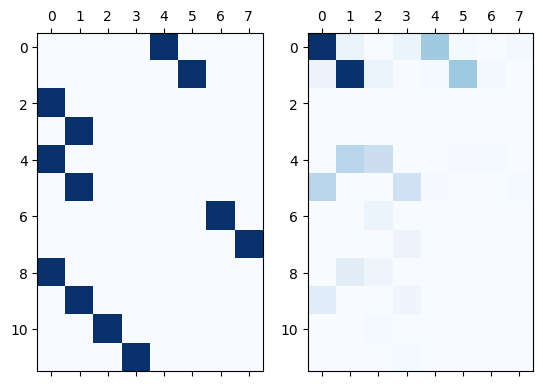

In [12]:
# plot frequencies of contact element pairs 

contact_state_freq = np.sum(np.sum(contact_state_hist_all, axis=3), axis=2) 

contact_state_paper = np.array([[0,0,0,0,1,0,0,0],
                                  [0,0,0,0,0,1,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,0,0,0,0,1,0],
                                  [0,0,0,0,0,0,0,1],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,1,0,0,0,0,0],
                                  [0,0,0,1,0,0,0,0]]) 

fig, axs = plt.subplots(1,2)

axs[0].matshow(contact_state_paper, cmap=plt.cm.Blues)
for i in range(contact_state_paper.shape[0]):
    for j in range(contact_state_paper.shape[1]):
        c = contact_state_paper[i,j] 
        
axs[1].matshow(contact_state_freq, cmap=plt.cm.Blues)
for i in range(contact_state_freq.shape[0]):
    for j in range(contact_state_freq.shape[1]):
        c = contact_state_freq[i,j]
        

In [13]:
# identify contact state types and label each contact state in history 
# RUNTIME: 
# 1.5m for 100 trials of 500 timesteps 
# 40m for 1000 trials of 500 timesteps
# 360m for 10000 trials of 500 timesteps 

contact_types_matrix_list = [] 
contact_types_matrix_freq = [] 
contact_type_idx_discover_list = [] 
contact_state_type_hist_all = np.zeros((N_timesteps, N_trials), dtype=int) - 1 
no_contact_matrix = np.zeros((len(hole_classes), len(peg_classes)), dtype=bool) 

for i in range(N_timesteps):    
    for j in range(N_trials): 

        contact_state_ij = contact_state_hist_all[:,:,i,j] 

        # label contact state type 
        for k, contact_type_k in enumerate(contact_types_matrix_list): 
            if np.array_equal(contact_state_ij, contact_type_k): 
                contact_state_type_hist_all[i,j] = k # label contact state type 
                contact_types_matrix_freq[k] += 1 
                contact_type_idx_discover_list.append(i*N_trials + j) 
                break # note: search could be optimized by reordering the list based on frequency of occurence 
        
        # if no match found, add new contact state type 
        if contact_state_type_hist_all[i,j] == -1 and not np.array_equal(contact_state_ij, no_contact_matrix): 
            contact_types_matrix_list.append(contact_state_ij) # add new contact state type to list 
            k_new = len(contact_types_matrix_list) - 1
            contact_state_type_hist_all[i,j] = k_new # new label for contact state type 
            contact_types_matrix_freq.append(1) # create new entry in frequency list and assign value of 1 
            contact_type_idx_discover_list.append(i*N_trials + j) 

N_contact_types = len(contact_types_matrix_list) 
print(f"{N_contact_types} unique contact state types found.") 

6113 unique contact state types found.


In [14]:
# save data 
dir_save = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/data_v4/processed_data_v2" 
if not os.path.exists(dir_save): 
    os.makedirs(dir_save) 
 
# save the following variables as pkl files 
with open(os.path.join(dir_save, "contact_state_hist_all.pkl"), 'wb') as f: 
    pickle.dump(contact_state_hist_all, f)

with open(os.path.join(dir_save, "contact_types_matrix_list.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_list, f)

with open(os.path.join(dir_save, "contact_types_matrix_freq.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_freq, f)

with open(os.path.join(dir_save, "contact_type_idx_discover_list.pkl"), 'wb') as f:
    pickle.dump(contact_type_idx_discover_list, f) 

with open(os.path.join(dir_save, "contact_state_type_hist_all.pkl"), 'wb') as f:
    pickle.dump(contact_state_type_hist_all, f) 

Text(0, 0.5, 'Fraction of Cases Captured of Total Found')

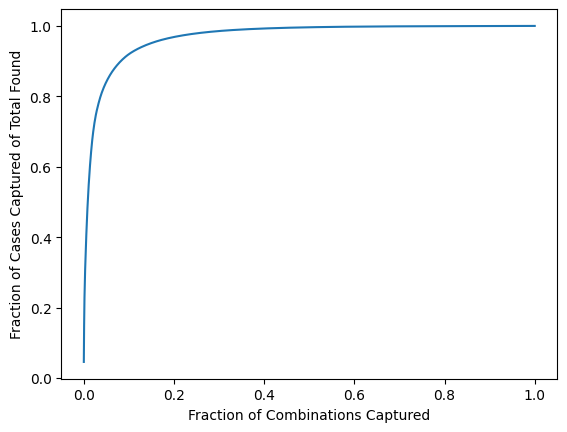

In [15]:
# plot of percent of cases captured by top N contact state types 
frac_cases_captured = np.zeros(N_contact_types)  
frac_combinations_captured = np.zeros(N_contact_types) 
for N in range(N_contact_types): 
    N_contact_types_top = N + 1 
    top_n = heapq.nlargest(N_contact_types_top, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
    top_values = [value for index, value in top_n]
    top_indices = [index for index, value in top_n]
    frac_cases_captured[N] = np.sum(top_values) / np.sum(contact_types_matrix_freq) 

# plot of contact state type frequency  
plt.figure()
plt.plot((np.arange(N_contact_types)+1)/N_contact_types, frac_cases_captured) 
plt.xlabel('Fraction of Combinations Captured') 
plt.ylabel('Fraction of Cases Captured of Total Found') 

Top N values: [87079, 69992, 44189, 42381, 40546, 40023, 34491, 27603, 25122, 23463, 20085, 19232, 18881, 18444, 17158, 17073, 15957, 13559, 12961, 12859, 12660, 12637, 12364, 12267, 12243, 11879, 11700, 11649, 11629, 11416, 11297, 11102, 10955, 10939, 10597, 10427, 10418, 10048, 10043, 9686, 9593, 9537, 9446, 9405, 9269, 9145, 8885, 8767, 8688, 8630, 8112, 8066, 7987, 7962, 7889, 7607, 7506, 7452, 7446, 7378, 7366, 7179, 7079, 6868, 6811, 6638, 6628, 6452, 6304, 6173, 6117, 6101, 6084, 6035, 6014, 5992, 5959, 5955, 5888, 5858, 5644, 5633, 5594, 5481, 5475, 5419, 5396, 5229, 5061, 5024, 4972, 4937, 4853, 4742, 4693, 4682, 4662, 4645, 4602, 4600]
Indices of top N values: [6, 819, 1, 0, 33, 15, 205, 1508, 2063, 311, 590, 219, 567, 94, 103, 61, 23, 29, 140, 256, 79, 525, 553, 18, 7, 45, 492, 4227, 230, 3346, 600, 495, 92, 3, 16, 844, 19, 119, 62, 41, 541, 361, 12, 511, 483, 151, 133, 2005, 37, 32, 995, 50, 467, 72, 48, 179, 39, 258, 52, 128, 480, 319, 2436, 500, 1066, 416, 616, 518, 235, 

Text(0.5, 1.0, 'Top N = 100 Contact State Type Frequency \n64.29% of cases captured by 1.64% of combinations')

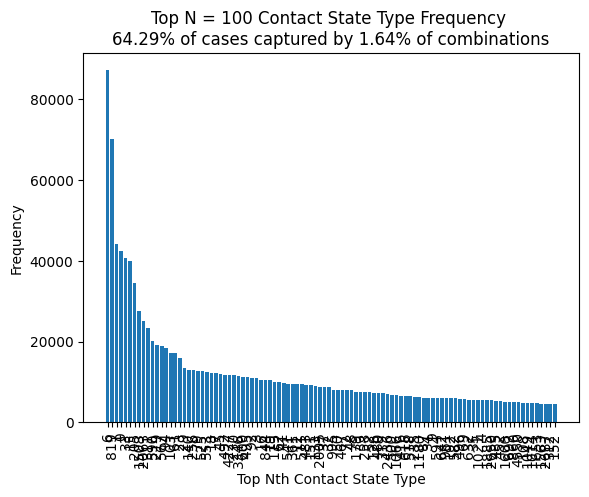

In [16]:
# find top N values and indices 
N_contact_types_top_freq = 100      
top_n = heapq.nlargest(N_contact_types_top_freq, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
top_values = [value for index, value in top_n]
top_indices = [index for index, value in top_n]
percent_cases_captured = np.sum(top_values) / np.sum(contact_types_matrix_freq) * 100 
percent_combinations_captured = N_contact_types_top_freq / N_contact_types * 100 

print("Top N values:", top_values)
print("Indices of top N values:", top_indices) 

# plot histogram of top N values 
plt.figure()
plt.bar(np.arange(N_contact_types_top_freq), top_values) 
plt.xticks(ticks=range(N_contact_types_top_freq), labels=top_indices)
plt.xticks(rotation=90)  # Rotate labels by 90 degrees
plt.xlabel("Top Nth Contact State Type")  
plt.ylabel("Frequency") 
plt.title(f"Top N = {N_contact_types_top_freq} Contact State Type Frequency \n{percent_cases_captured:.2f}% of cases captured by {percent_combinations_captured:.2f}% of combinations")  

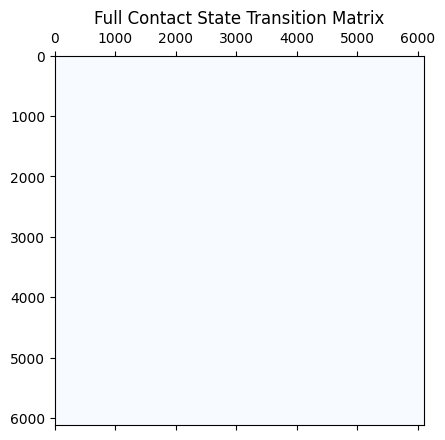

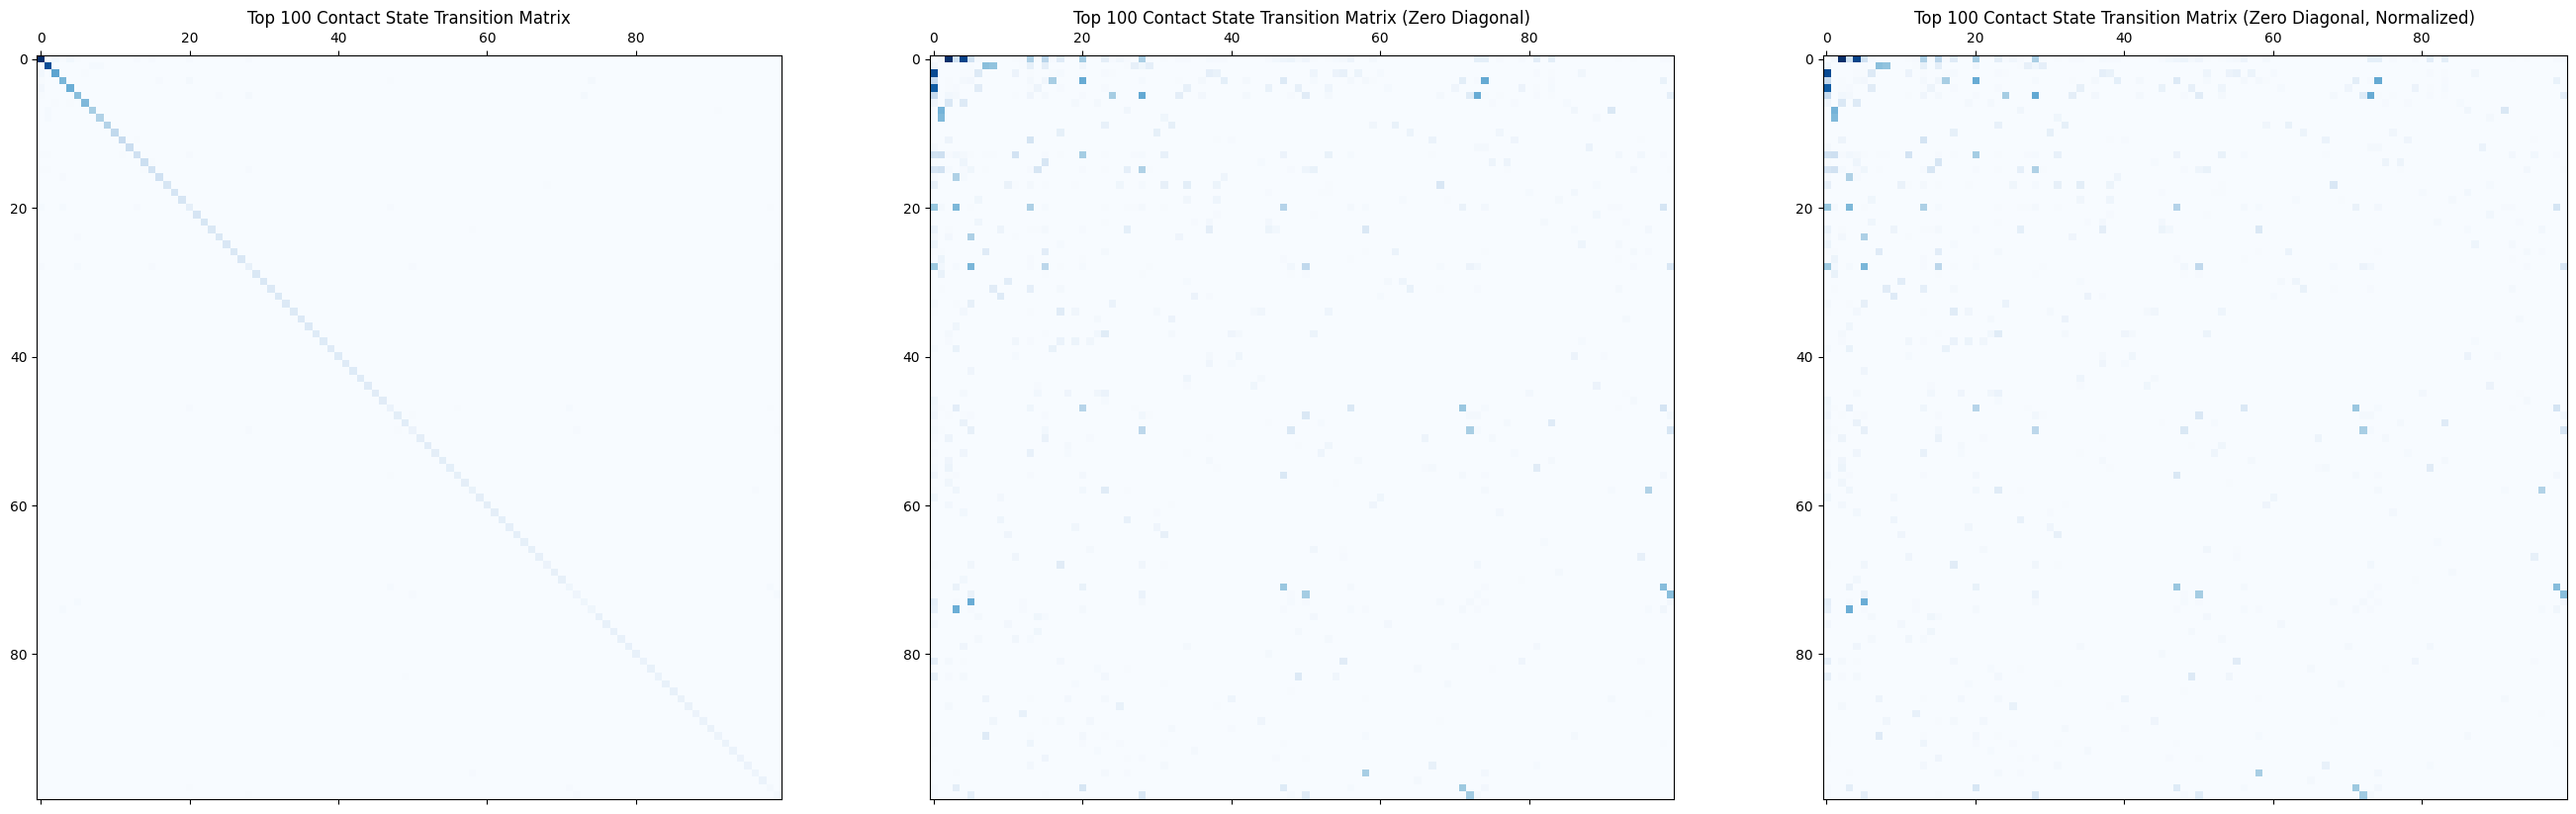

In [17]:
# identify all unique contact state type transitions and label each transition in history 

contact_state_transition_matrix = np.zeros((N_contact_types, N_contact_types), dtype=int) 
for i in range(N_timesteps-1): 
    for j in range(N_trials): 
        contact_state_type_i = contact_state_type_hist_all[i,j] 
        contact_state_type_ip1 = contact_state_type_hist_all[i+1,j] 
        contact_state_transition_matrix[contact_state_type_i, contact_state_type_ip1] += 1 

# plot state transition matrix 
fig, axs = plt.subplots()
axs.matshow(contact_state_transition_matrix, cmap=plt.cm.Blues)
axs.set_title("Full Contact State Transition Matrix")
for i in range(contact_state_transition_matrix.shape[0]):
    for j in range(contact_state_transition_matrix.shape[1]):
        c = contact_state_transition_matrix[i,j] 

# only plot top N transitions 
contact_state_transition_matrix_top_N = np.zeros((N_contact_types_top_freq, N_contact_types_top_freq), dtype=int)   
for i, index_i in enumerate(top_indices): 
    for j, index_j in enumerate(top_indices): 
        contact_state_transition_matrix_top_N[i,j] = contact_state_transition_matrix[index_i, index_j] 

# plot state transition matrix 
fig, axs = plt.subplots(1,3,figsize=(33,10))
axs[0].matshow(contact_state_transition_matrix_top_N, cmap=plt.cm.Blues)
axs[0].set_title(f"Top {N_contact_types_top_freq} Contact State Transition Matrix")
for i in range(contact_state_transition_matrix_top_N.shape[0]):
    for j in range(contact_state_transition_matrix_top_N.shape[1]):
        c = contact_state_transition_matrix_top_N[i,j] 

# plot state transition matrix where diagonal is set to zero 
contact_state_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_state_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[1].matshow(contact_state_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[1].set_title(f"Top {N_contact_types_top_freq} Contact State Transition Matrix (Zero Diagonal)")
for i in range(contact_state_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_state_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_state_transition_matrix_top_N_no_diag[i,j] 

# plot state transition matrix where diagonal is set to zero and offdiagonal values are normalized by frequency of occurence of the source state 
contact_state_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_state_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[2].matshow(contact_state_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[2].set_title(f"Top {N_contact_types_top_freq} Contact State Transition Matrix (Zero Diagonal, Normalized)") 
for i in range(contact_state_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_state_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_state_transition_matrix_top_N_no_diag[i,j] / top_values[j]  


In [51]:
# gather all wrench values for each contact state type in a pandas dataframe 

# read in pkl file 
dir_pkl = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/data_v4/pkl"

# list all pkl files in the directory 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

# list of all contact state history 
N_timesteps = 500 
N_trials = 5000 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 

# initialize data structure for wrench values 
wrench_hist_all = np.zeros((6, N_timesteps, N_trials)) 
wrench_and_contact_state_hist_all = np.zeros((N_timesteps*N_trials, 6+1))  
time_pose_wrench_contact_state_hist_all = np.zeros((N_timesteps*N_trials, 1+7+6+1)) 

for i, pkl_file in enumerate(pkl_files): 
    state_hist = data['state_hist'] 
    sensor_hist = data['sensor_hist'] 
    wrench_hist_all[:,:,i] = sensor_hist[:,:6].transpose() 

    for j in range(N_timesteps): 
        sensor_hist_ij = sensor_hist[j,:6] 
        state_hist_ij = state_hist[j,:]
        contact_state_type_ij = contact_state_type_hist_all[j,i] 
        wrench_and_contact_state_hist_all[i*N_timesteps + j,:] = np.concatenate((sensor_hist_ij, np.array([contact_state_type_ij]))).transpose()  
        time_pose_wrench_contact_state_hist_all[i*N_timesteps + j,:] = np.concatenate((state_hist_ij, sensor_hist_ij, np.array([contact_state_type_ij]))).transpose() 

# save data as csv with headers 
df_wrench_contact_type = pd.DataFrame(wrench_and_contact_state_hist_all, columns=['FX','FY','FZ','TX','TY','TZ','contact_type'])  
df_wrench_contact_type.to_csv(os.path.join(dir_save, "wrench_and_contact_state_hist_all.csv")) 

df_pose_wrench_contact_type = pd.DataFrame(time_pose_wrench_contact_state_hist_all, columns=['T','X','Y','Z','QX','QY','QZ','QW','FX','FY','FZ','TX','TY','TZ','contact_type'])
df_pose_wrench_contact_type.to_csv(os.path.join(dir_save, "pose_wrench_and_contact_state_hist_all.csv")) 